In [1]:
import utils.sampling as smp
import matplotlib.pyplot as plt
import tree
import pickle
import tree.halomodule as hmo
import numpy as np
from analysis.misc import load_cat
import scipy.stats
import tree.ctutils as ctu
#from analysis.evol_lambda_HM import MainPrg
import draw
import load


class MainPrg():
    def __init__(self, idx, nnza):
        """
            Separate tree data and lambda catalog data. 
            
            early snapshot first.
        """
        self.root_idx = idx
        self.nsteps = nnza["nstep"] # truncate later.
        #self.idxs = np.zeros(len(nnza), dtype=int)
        #self.ids = np.zeros(len(nnza), dtype=int)
        self.nouts = nnza["nout"]
        self.zreds = nnza["zred"]
        self.aexps = 1/(1+self.zreds)       
        
    def initialize_data(self, cat, force=False):
        if hasattr(self, "data"):
            if not force:
                print("self.data already exists. use force=True to re-initialize it.")
                pass
        else:
            self.data=np.zeros(len(self.nsteps),
                                  dtype=cat.dtype)

    def set_data(self, cat, nout):
        ind = np.where(cat["tree_root_id"] == self.root_idx)[0]
        if len(ind) == 1:
            self.data
            inout = np.where(self.nouts == nout)[0]
            if len(inout) == 1:
                self.data[inout] = cat[ind]
                #self.id[inout] = cat[ind]["id"]
    
    def fill_missing_data(self):
        assert (self.ids[0] != 0)
        # position angles cannot be linearly interpolated.
        # skip.
        #
        # position and velocity are also not that linear..
        # but let me just interpolate them.
        # 
        # excluded=["lambda_arr2"]
        filled_fields = ["eps", "epsh", "epsq", "lambda_12kpc",
                         "lambda_arr", "lambda_arrh",
                         "lambda_r","lambda_r12kpc",
                         "lambda_r2","lambda_rh","mgas","mrj","mstar",
                         "reff","reff2","rgal","rgal2","rscale_lambda",
                         "sfr","sma","smah","smaq","smi","smih","smiq","ssfr",
                         "vxc", "vyc", "vzc", "xc", "yc", "zc"]

        i_good_max = max(np.where(self.data["reff"] > 0)[0])
        i_bad = np.where(self.data['idx'] == 0)[0]
        i_bad = i_bad[i_bad < i_good_max]
        if len(i_bad) > 0:
            for field in filled_fields:
                # do not modify index and id fields.
                arr = self.data[field] # it's a view.

                for i_b in i_bad:
                    # neighbouring array might also be empty. Search for closest valid element.
                    # left point
                    i_l = i_b - 1 
                    while(i_l in i_bad):
                        i_l = i_l - 1 
                    # right point
                    i_r = i_b + 1 
                    while(i_r in i_bad):
                        i_r = i_r + 1 
                    arr[i_b] = (arr[i_b -1] + arr[i_b +1])/2.
    
    def truncate(self):
        imax = np.where(self.data["lambda_r"] > 0)[0] + 1
        self.nsteps = self.nsteps[:imax]
        self.nouts = self.nouts[:imax]
        self.zreds = self.zreds[:imax]
        self.aexps = self.aexps[:imax]

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
wdir = '/home/hoseung/Work/data/Horizon-AGN/'
nout_fi = 782

# Serialize catalogs. -> Only main galaxies
# main galaxy list
#alltrees = ctu.load_tree(wdir, is_gal=True)
#ad = alltrees.data
#tn = ad[ad['nout'] == nout_fi]

In [4]:
nnza = np.genfromtxt(wdir + "nout_nstep_zred_aexp.txt",
                     dtype=[("nout", int),
                            ("nstep", int),
                            ("zred", float),
                            ("aexp", float)])

#mpgs = pickle.load(open(wdir + "MPGS_data_set.pickle", "rb"))

In [5]:
from analysis.misc import load_cat
from analysis.all_plot_modules import *
from analysis.MajorMinorAccretion_module import *

In [6]:
load_init = False
if load_init:
    mpgs = pickle.load(open(wdir + "MPGS_init.pickle", "rb"))
else:
    mpgs=[]
    samples = [0,1,2,3,4,6,7,8,9,10,11,12,13,15,16,17,18,19,20]
    for sample in samples:
        # initialize mpgs
        ss = str(sample)
        f_cat = load_cat(wdir + 'lambda_results/' + ss + '/catalog' + str(nout_fi) + ss +'.pickle')
        root_idx_all = f_cat['idx'][f_cat["idx"] > 0].astype(int) # why idx are float???
        for i, idx in enumerate(root_idx_all):
            mpgs.append(MainPrg(idx, nnza))

        # assign lambda measurement data
        for nout in nnza["nout"][:1]:
            cat = load_cat(wdir + 'lambda_results/' + ss + '/catalog' + str(nout) + ss +'.pickle')
            #print(nout)
            for gal in mpgs:
                if nout == 782:
                    gal.initialize_data(cat, force=True)
                gal.set_data(cat, nout)
        
    for gal in mpgs:
        gal.ids = gal.data["id"]
        gal.idxs = gal.data["idx"]
        #self.ids = np.zeros(len(nnza), dtype=int)

Measure d5 of all galaxies in the catalog.
Not just for the galaxies with lambda measurement.

In [7]:
from tree import halomodule as hmo
allgal = hmo.Halo(nout=782, is_gal=True, base=wdir)

import load
info = load.info.Info(nout=782, base=wdir)

galidlist = []
for gal in mpgs:
    galidlist.append(gal.ids[0])

[Halo.load_info] loading info
[Halo.load_info] nout = 782, base =/home/hoseung/Work/data/Horizon-AGN/


In [8]:
xall = allgal.data["x"]
yall = allgal.data["y"]
zall = allgal.data["z"]

bins = np.linspace(0, 1, 20)

xbin = np.digitize(xall, bins)
ybin = np.digitize(yall, bins)
zbin = np.digitize(zall, bins)

dist_cut = 5/info.pboxsize

d5 = []
N5 = []
for idgal in galidlist:
#for igal in range(len(allgal.data)):
    igal = np.where(allgal.data["id"] == idgal)[0]
    x_this = allgal.data["x"][igal]
    y_this = allgal.data["y"][igal]
    z_this = allgal.data["z"][igal]
    
    # get subsample to speed up the code
    xb_this = xbin[igal]
    yb_this = ybin[igal]
    zb_this = zbin[igal]
    
    first_candidates = allgal.data[(np.abs(xbin - xb_this) < 2) \
                                  * (np.abs(ybin - yb_this) < 2)\
                                  * (np.abs(zbin - zb_this) < 2)]
    
    dist = np.sqrt(np.square(first_candidates["x"] - x_this) + 
                   np.square(first_candidates["y"] - y_this) + 
                   np.square(first_candidates["z"] - z_this))
    #print(len(dist))
    N5.append(sum(dist < dist_cut))
    d5.append(np.sort(dist)[4] * info.pboxsize)

What is the d5 of top 20% galaxies?

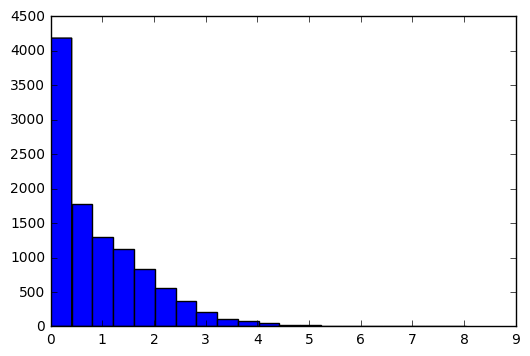

In [10]:
plt.hist(d5, bins=20)
plt.show()

~50% = 1Mpc.

In [11]:
d5_80 = d5[np.argsort(d5)[np.ceil(0.8 * len(d5)).astype(int)]]
i_isol = np.where(d5 >= d5_80)[0]
isolated = [mpgs[i] for i in i_isol]

d5_20 = d5[np.argsort(d5)[np.ceil(0.2 * len(d5)).astype(int)]]
i_dense = np.where(d5 <= d5_20)[0]
dense = [mpgs[i] for i in i_dense]

In [12]:
mgal_a = np.array([gal.data["mstar"][0] for gal in mpgs])
lambda_a = np.array([gal.data["lambda_r"][0] for gal in mpgs])

mgal_i = np.array([gal.data["mstar"][0] for gal in isolated])
lambda_i = np.array([gal.data["lambda_r"][0] for gal in isolated])

mgal_d = np.array([gal.data["mstar"][0] for gal in dense])
lambda_d = np.array([gal.data["lambda_r"][0] for gal in dense])

In [13]:
print(len(isolated), len(dense))

2130 2131


In [14]:
# Cluster sample
mpgs_c = pickle.load(open("/home/hoseung/Work/data/all_prgs/main_prgs_final_augmented_5_10_0.5_0.5_0.5_37_0.01_filtered_.pickle", "rb"))

In [15]:
eps_c = []
lambda_c = []
mgal_c = []
inout = 0 # nout=187
mstar_cut_hard = 5e9

inout = 0
for gal in mpgs_c:
    mgal = gal.data["mstar"][0]
    if mgal > mstar_cut_hard:
        eps_c.append(gal.data['eps'][inout])
        lambda_c.append(gal.data['lambda_r'][inout])
        mgal_c.append(gal.data['mstar'][inout])

In [252]:
def fill_between(x,y,ax,nbins=10,
                 std=False,
                 percentile=0,
                 xpos_type=None,
                 bintype = "uniform_size",
                 linedata = "mean",
                 alpha=0.5,
                 color='blue'):
    if xpos_type is None:
        if bintype == "uniform_size":
            xpos_type = "median"
        elif bintype == "uniform_width":
            xpos_type = "mean"
    
    if percentile == 0:
        std = True
    if std:
        n, bins = np.histogram(x, bins=nbins)
        sy, bins = np.histogram(x, bins=nbins, weights=y)
        sy2, bins = np.histogram(x, bins=nbins, weights=y*y)
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)
        y_upper = mean + std
        y_lower = mean - std
        xpos = (bins[1:] + bins[:-1])/2
    elif percentile > 0:
        if bintype == "uniform_width":
            x = x[np.argsort(x)]
            y = y[np.argsort(x)]
            n, bins = np.histogram(x, bins=nbins)
            bins[-1] += 0.0001 # last element in the last bin.
            binned_x = x[np.digitize(x, bins)]
            dgt = np.digitize(x, bins)
            binned_x = [x[dgt == i] for i in range(1,nbins+1)]
            binned_y = [y[dgt == i] for i in range(1,nbins+1)]
            xpos = (bins[1:] + bins[:-1])/2
        elif bintype == "uniform_size":
            binned_x = np.array_split(x[np.argsort(x)], nbins)
            binned_y = np.array_split(y[np.argsort(x)], nbins)
            
        mean, y_upper, y_lower=[], [], []
        if bintype != "uniform_width":
            xpos = []

        if percentile > 1:
            percentile /=100

        for xb, yb in zip(binned_x, binned_y):
            if len(xb) < 1 :
                print("Too small sized sample. aborting.. ")
                return
            if bintype != "uniform_width":
                xpos.append((min(xb) + max(xb))/2)
            if linedata == "median":
                mean.append(np.median(yb))# it's actually mean.
            elif linedata == "mean":
                mean.append(np.mean(yb))
            ybsrt = np.argsort(yb)
            y_upper.append(yb[ybsrt[np.floor(len(yb)*(1-percentile))]])
            y_lower.append(yb[ybsrt[np.floor(len(yb)*(percentile))]])                

    ax.fill_between(xpos, y_lower, y_upper, color=color, alpha=alpha)
    ax.plot(xpos, mean, color=color, linewidth=2)

def mean_std(x,y,ax, nbins=10, **kwargs):
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, **kwargs)

def mean_alone(x,y,ax, nbins=10, **kwargs):
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    #sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    #std = np.sqrt(sy2/n - mean*mean)
    ax.plot((_[1:] + _[:-1])/2, mean, **kwargs)

## Median

/home/hoseung/mypy/lib/python3.5/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/hoseung/mypy/lib/python3.5/site-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


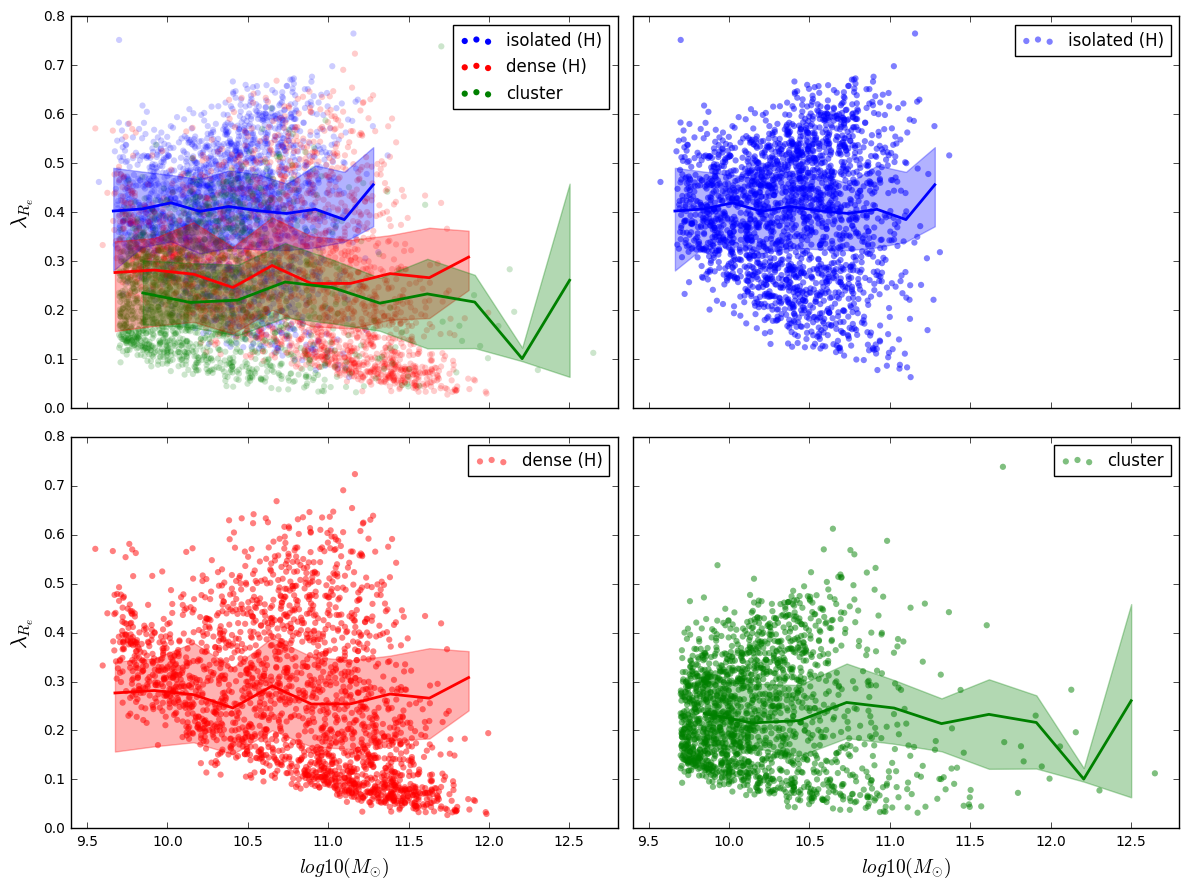

In [256]:
import pylab
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(12,9)
nbins = 10

#fill_between(np.log10(np.array(mgal_a)), np.array(lambda_a), axs[0,0], color = "gray",
#             **fill_between_args)
do_fill_between=True
do_mean_std = False
do_mean_alone = False
do_scatter = True

if do_scatter:
    scatter_args = {"edgecolor":"none", "alpha":0.2}
    #axs[0,0].scatter(np.log10(mgal_a), lambda_a, **scatter_args, c='grey', label="All (H)")
    axs[0,0].scatter(np.log10(mgal_i), lambda_i, **scatter_args, c='b', label="isolated (H)")
    axs[0,0].scatter(np.log10(mgal_d), lambda_d, **scatter_args, c='r', label="dense (H)")
    axs[0,0].scatter(np.log10(mgal_c), lambda_c, **scatter_args, c='g', label="cluster")


if do_fill_between:
    fill_between_args ={"bintype":"uniform_width", 
             "linedata":"median",
             "nbins":nbins, "percentile":30, "alpha":0.3}

    fill_between(np.log10(np.array(mgal_i)), np.array(lambda_i), axs[0,0], color = "b",
                 **fill_between_args)
    fill_between(np.log10(np.array(mgal_d)), np.array(lambda_d), axs[0,0], color = "r",
                 **fill_between_args)
    fill_between(np.log10(np.array(mgal_c)), np.array(lambda_c), axs[0,0], color = "g",
                 **fill_between_args)

if do_mean_std:
    mean_std(np.log10(mgal_i), lambda_i, axs[0,0], nbins=nbins, fmt='b-', linewidth=3)
    mean_std(np.log10(mgal_d), lambda_d, axs[0,0], nbins=nbins, fmt='r-', linewidth=3)
    mean_std(np.log10(mgal_c), lambda_c, axs[0,0], nbins=nbins, fmt='g-', linewidth=3)

if do_mean_alone:
    mean_alone(np.log10(mgal_i), lambda_i, axs[0,0], nbins=nbins, color='b', linewidth=3)
    mean_alone(np.log10(mgal_d), lambda_d, axs[0,0], nbins=nbins, color='r', linewidth=3)
    mean_alone(np.log10(mgal_c), lambda_c, axs[0,0], nbins=nbins, color='g', linewidth=3)
    
#line1 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="gray",alpha=1.0)
line2 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="b",alpha=1.0)
line3 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="r",alpha=1.0)
line4 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="g",alpha=1.0)
axs[0,0].legend((line2,line3,line4),('isolated (H)', 'dense (H)', "cluster"),numpoints=3,loc=1)

axs[0,0].plot()
#

mean_std_individual_args = {"linewidth":3, "fmt":"-", "nbins":nbins}
scatter_individual_args = {"edgecolor":"none", 
                            "alpha":0.5}
axs[0,1].scatter(np.log10(mgal_i), lambda_i, edgecolor="none", alpha=0.5, label="isolated (H)", c='b')
#mean_std(np.log10(mgal_i), lambda_i, axs[0,1], color="gray", **mean_std_individual_args)
fill_between(np.log10(np.array(mgal_i)), np.array(lambda_i), axs[0,1], color = "b",
                 **fill_between_args)
    
axs[0,1].legend()
axs[1,0].scatter(np.log10(mgal_d), lambda_d, edgecolor="none", alpha=0.5, c='r', label="dense (H)")
#mean_std(np.log10(mgal_d), lambda_d, axs[1,0], color="gray", **mean_std_individual_args)
fill_between(np.log10(np.array(mgal_d)), np.array(lambda_d), axs[1,0], color = "r",
                 **fill_between_args)
    
axs[1,0].legend()
axs[1,1].scatter(np.log10(mgal_c), lambda_c, edgecolor="none", alpha=0.5, c='g', label="cluster")
fill_between(np.log10(np.array(mgal_c)), np.array(lambda_c), axs[1,1], color = "g",
                 **fill_between_args)
#mean_std(np.log10(mgal_c), lambda_c, axs[1,1], color="gray", **mean_std_individual_args)
axs[1,1].legend()

for ax in axs.ravel():
    ax.set_xlim([9.4,12.8])
    ax.set_ylim([0,0.8])

axs[1,0].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[1,1].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[0,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
axs[1,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
plt.tight_layout()
plt.savefig("/home/hoseung/Work/data/figs2/LambdaVsMstar_Env_mean2.png", dpi=150)
plt.show()

## Mean

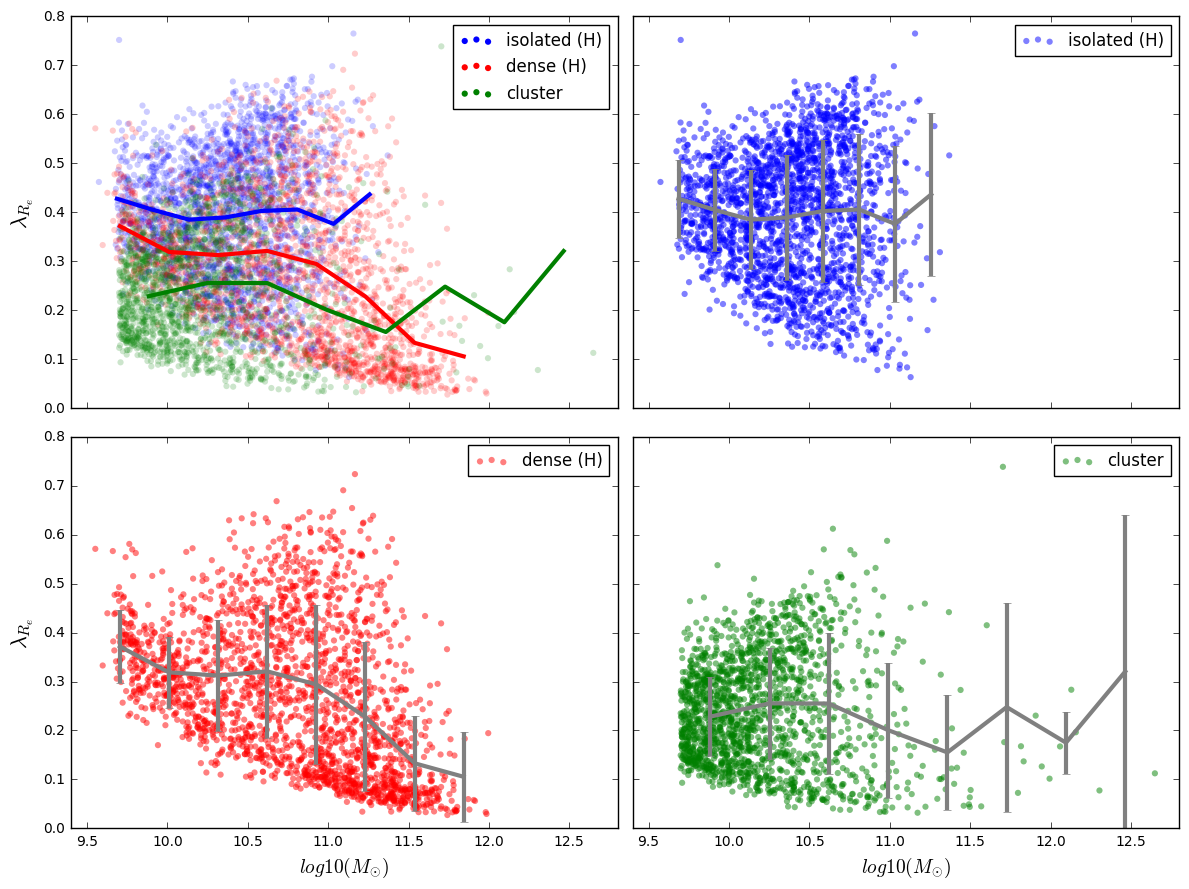

In [243]:
import pylab
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(12,9)
nbins = 8

#fill_between(np.log10(np.array(mgal_a)), np.array(lambda_a), axs[0,0], color = "gray",
#             **fill_between_args)
do_fill_between=False
do_mean_std = False
do_mean_alone = True
do_scatter = True

if do_scatter:
    scatter_args = {"edgecolor":"none", "alpha":0.2}
    #axs[0,0].scatter(np.log10(mgal_a), lambda_a, **scatter_args, c='grey', label="All (H)")
    axs[0,0].scatter(np.log10(mgal_i), lambda_i, **scatter_args, c='b', label="isolated (H)")
    axs[0,0].scatter(np.log10(mgal_d), lambda_d, **scatter_args, c='r', label="dense (H)")
    axs[0,0].scatter(np.log10(mgal_c), lambda_c, **scatter_args, c='g', label="cluster")


if do_fill_between:
    fill_between_args ={"bintype":"uniform_width", 
             "linedata":"median",
             "nbins":nbins, "percentile":30, "alpha":0.0}

    fill_between(np.log10(np.array(mgal_i)), np.array(lambda_i), axs[0,0], color = "b",
                 **fill_between_args)
    fill_between(np.log10(np.array(mgal_d)), np.array(lambda_d), axs[0,0], color = "r",
                 **fill_between_args)
    fill_between(np.log10(np.array(mgal_c)), np.array(lambda_c), axs[0,0], color = "g",
                 **fill_between_args)

if do_mean_std:
    mean_std(np.log10(mgal_i), lambda_i, axs[0,0], nbins=nbins, fmt='b-', linewidth=3)
    mean_std(np.log10(mgal_d), lambda_d, axs[0,0], nbins=nbins, fmt='r-', linewidth=3)
    mean_std(np.log10(mgal_c), lambda_c, axs[0,0], nbins=nbins, fmt='g-', linewidth=3)

if do_mean_alone:
    mean_alone(np.log10(mgal_i), lambda_i, axs[0,0], nbins=nbins, color='b', linewidth=3)
    mean_alone(np.log10(mgal_d), lambda_d, axs[0,0], nbins=nbins, color='r', linewidth=3)
    mean_alone(np.log10(mgal_c), lambda_c, axs[0,0], nbins=nbins, color='g', linewidth=3)
    
#line1 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="gray",alpha=1.0)
line2 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="b",alpha=1.0)
line3 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="r",alpha=1.0)
line4 = pylab.scatter(range(1),range(1),edgecolor='none',marker='o', facecolor="g",alpha=1.0)
axs[0,0].legend((line2,line3,line4),('isolated (H)', 'dense (H)', "cluster"),numpoints=3,loc=1)

axs[0,0].plot()
#

mean_std_individual_args = {"linewidth":3, "fmt":"-", "nbins":nbins}
scatter_individual_args = {"edgecolor":"none", 
                            "alpha":0.5}
axs[0,1].scatter(np.log10(mgal_i), lambda_i, edgecolor="none", alpha=0.5, label="isolated (H)", c='b')
mean_std(np.log10(mgal_i), lambda_i, axs[0,1], color="gray", **mean_std_individual_args)
axs[0,1].legend()
axs[1,0].scatter(np.log10(mgal_d), lambda_d, edgecolor="none", alpha=0.5, c='r', label="dense (H)")
mean_std(np.log10(mgal_d), lambda_d, axs[1,0], color="gray", **mean_std_individual_args)
axs[1,0].legend()
axs[1,1].scatter(np.log10(mgal_c), lambda_c, edgecolor="none", alpha=0.5, c='g', label="cluster")
mean_std(np.log10(mgal_c), lambda_c, axs[1,1], color="gray", **mean_std_individual_args)
axs[1,1].legend()

for ax in axs.ravel():
    ax.set_xlim([9.4,12.8])
    ax.set_ylim([0,0.8])

axs[1,0].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[1,1].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[0,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
axs[1,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
plt.tight_layout()
plt.savefig("/home/hoseung/Work/data/figs2/LambdaVsMstar_Env_mean.png", dpi=150)
plt.show()

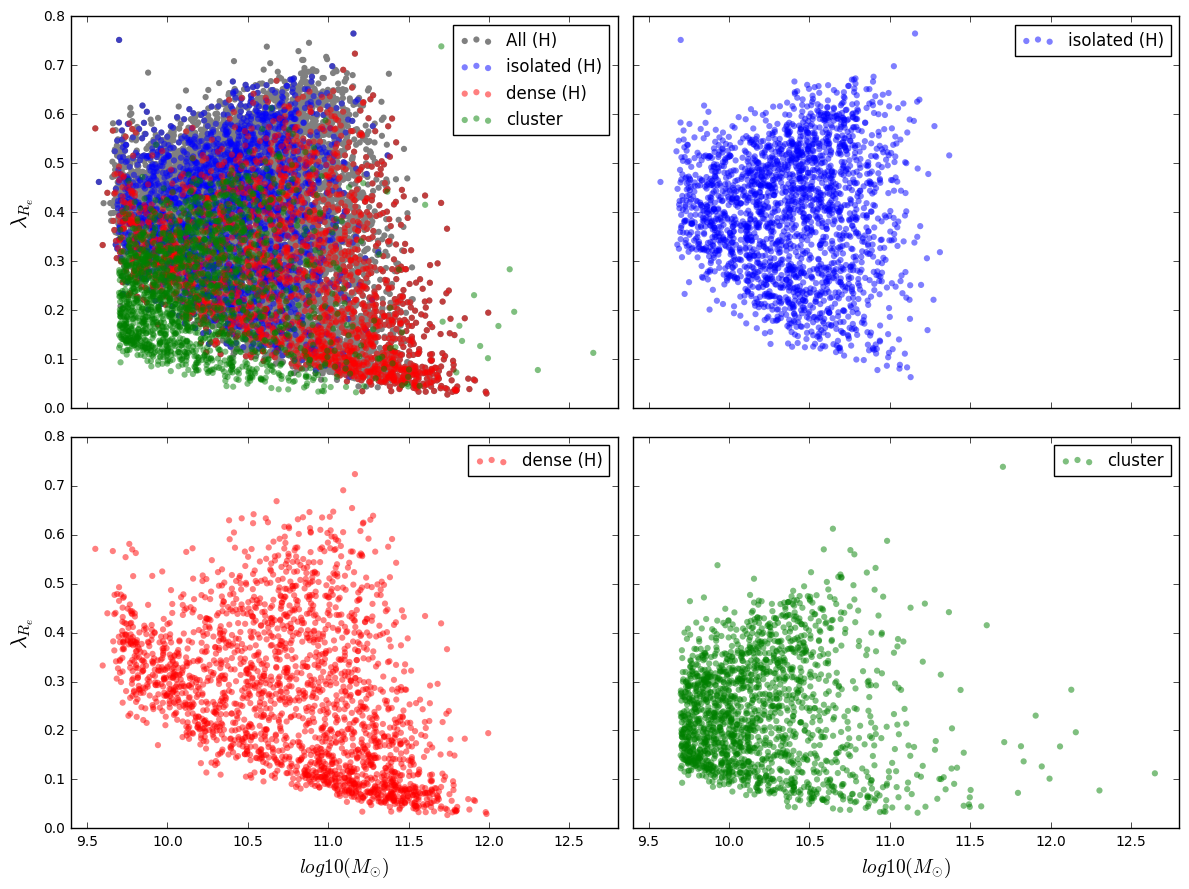

In [17]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(12,9)
axs[0,0].scatter(np.log10(mgal_a), lambda_a, c='grey', edgecolor="none", label="All (H)")
axs[0,0].scatter(np.log10(mgal_i), lambda_i, c='b', edgecolor="none",label="isolated (H)", alpha=0.5)
axs[0,0].scatter(np.log10(mgal_d), lambda_d, c='r', edgecolor="none", label="dense (H)", alpha=0.5)
axs[0,0].scatter(np.log10(mgal_c), lambda_c, c='g', edgecolor="none", label="cluster", alpha=0.5)
axs[0,0].legend()

axs[0,1].scatter(np.log10(mgal_i), lambda_i, c='b', edgecolor="none",label="isolated (H)", alpha=0.5)
axs[0,1].legend()
axs[1,0].scatter(np.log10(mgal_d), lambda_d, c='r', edgecolor="none", label="dense (H)", alpha=0.5)
axs[1,0].legend()
axs[1,1].scatter(np.log10(mgal_c), lambda_c, c='g', edgecolor="none", label="cluster", alpha=0.5)
axs[1,1].legend()

for ax in axs.ravel():
    ax.set_xlim([9.4,12.8])
    ax.set_ylim([0,0.8])

axs[1,0].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[1,1].set_xlabel(r"$log10(M_{\odot})$", fontsize=14)
axs[0,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
axs[1,0].set_ylabel(r"$\lambda_{R_{e}}$", fontsize=16)
plt.tight_layout()
plt.savefig("LambdaVsMstar_Env.png", dpi=150)
plt.show()

In [13]:
fig, ax = plt.subplots()

samples = [0,1,2,3,4,6,7,8,9,10,11,12,13,15,16,17,18,19,20,1000]
for sample in samples:
    # initialize mpgs
    ss = str(sample)
    f_cat = load_cat(wdir + 'lambda_results/' + ss + '/catalog' + str(nout_fi) + ss +'.pickle')
    if sample == 1000:
        ax.scatter(nf_cat["mstar"]), f_cat["lambda_r"], c='r')
    else:
        ax.scatter(np.log10(f_cat["mstar"]), f_cat["lambda_r"], c='b')
    
    
ax.set_ylim(0,0.8)

(0, 0.8)

In [31]:
clusters=[6098, 7206, 29172, 29176]
for cluster in clusters[:3]:
    cat = load_cat("/home/hoseung/Work/data/" + str(cluster).zfill(5) + "/easy_final/catalog187.pickle")
    plt.scatter(np.log10(cat["mstar"]), cat["lambda_r"], c='r')

In [32]:
clusters=[6098, 7206, 29172, 29176]
for cluster in clusters[3:]:
    cat = load_cat("/home/hoseung/Work/data/" + str(cluster).zfill(5) + "/easy_final/catalog187.pickle")
    plt.scatter(np.log10(cat["mstar"]), cat["lambda_r"], c='b')

In [33]:
plt.show()